In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load and prepare the MNIST dataset
transform = transforms.ToTensor()
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4585884.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 58329.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 450528.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9220972.30it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [20]:
# Define the Convolutional Variational Autoencoder model
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # [32, 28, 28]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # [32, 14, 14]
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # [64, 14, 14]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # [64, 7, 7]
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # [128, 7, 7]
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(128 * 7 * 7, 32)
        self.fc_logvar = nn.Linear(128 * 7 * 7, 32)
        self.fc_decode = nn.Linear(32, 128 * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),  # [128, 14, 14]
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # [64, 14, 14]
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # [64, 28, 28]
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # [32, 28, 28]
            nn.ReLU(True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # [1, 28, 28]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [21]:
# Instantiate the model, define the loss function and the optimizer
model = ConvVAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training the VAE
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.view(-1, 1, 28, 28)
        outputs, mu, logvar = model(inputs)
        loss = loss_function(outputs, inputs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(trainloader.dataset):.4f}')

Epoch [1/20], Loss: 130.7870
Epoch [2/20], Loss: 105.3862
Epoch [3/20], Loss: 102.9084
Epoch [4/20], Loss: 101.6441
Epoch [5/20], Loss: 100.7743
Epoch [6/20], Loss: 100.1145
Epoch [7/20], Loss: 99.5484
Epoch [8/20], Loss: 99.0708
Epoch [9/20], Loss: 98.6907
Epoch [10/20], Loss: 98.2918
Epoch [11/20], Loss: 98.0244
Epoch [12/20], Loss: 97.7034
Epoch [13/20], Loss: 97.4592
Epoch [14/20], Loss: 97.2367
Epoch [15/20], Loss: 97.0050
Epoch [16/20], Loss: 96.8492
Epoch [17/20], Loss: 96.7111
Epoch [18/20], Loss: 96.5416
Epoch [19/20], Loss: 96.3515
Epoch [20/20], Loss: 96.1749


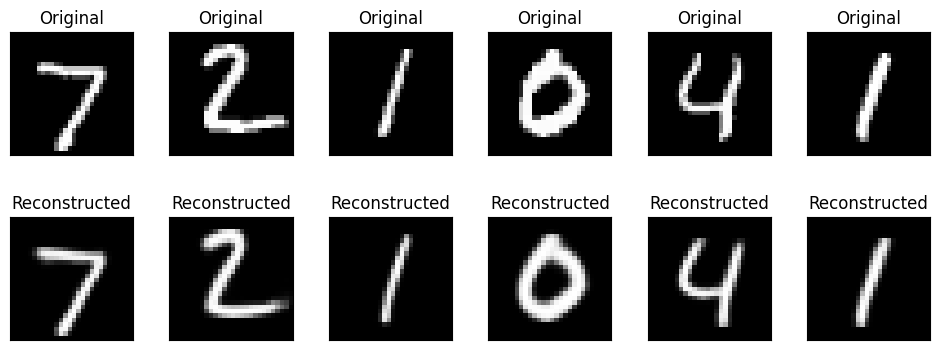

In [22]:
# Function to visualize some results
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        images, _ = next(dataiter)  # Use next() to get the first batch of images and labels
        images = images.view(-1, 1, 28, 28)
        outputs, _, _ = model(images)

        # Show original and reconstructed images
        plt.figure(figsize=(12, 4))
        for i in range(6):
            ax = plt.subplot(2, 6, i + 1)
            plt.imshow(images[i].view(28, 28).cpu().numpy(), cmap='gray')
            plt.title("Original")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        for i in range(6):
            ax = plt.subplot(2, 6, i + 7)
            plt.imshow(outputs[i].view(28, 28).cpu().numpy(), cmap='gray')
            plt.title("Reconstructed")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.subplots_adjust(hspace=0.5)  # Adjust the height space between rows
        plt.show()

# Visualize some reconstructed images
visualize_reconstruction(model, testloader)